# import stuff

In [1]:
%load_ext autoreload
%autoreload 2

# import python stuff
import matplotlib.pyplot as plt
import numpy as np

import scipy
import scipy.special as spe
from scipy import optimize
from scipy.stats import poisson
from qutip import *
import iminuit
import time
import multiprocessing as mp
from platform import python_version
import os

# import my functions
from functionsSqueeze import *
from functions_SpinPhonon import *

# import existing Paula funcitons
from PyModules.analyse_eios import eios_sb
from PyModules.analyse_eios import eios_analyse
from PyModules.analyse_eios import eios_data

print("python version:", python_version())
print("number of CPU's:", mp.cpu_count())

python version: 3.6.9
number of CPU's: 8


# Poisson Fits for two ions

## define poisson fit functions (equivalent funcitons to the ones for one ion in eios_analyse)

In [27]:
# def plot_hist_res_2I(hist, res):
#     xx = np.linspace(0, 30, 31)
#     mu_dd, mu_du, mu_uu = res['x'][0], res['x'][1], res['x'][2]
#     p_dd, p_du, p_uu = res['x'][3], res['x'][4], res['x'][5]
    
#     y = p_dd*poisson.pmf(xx, mu_dd) + p_du*poisson.pmf(xx, mu_du) + p_uu*poisson.pmf(xx, mu_uu)
# #     y = [(res['x'][2]+res['x'][3])*poisson.pmf(i, res['x'][0]) + (2-res['x'][2]-res['x'][3])*poisson.pmf(i, res['x'][1]) for i in xx]
    
#     plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
#     plt.plot(xx, y/np.sum(y))
#     plt.show()

## do the fitting

processing time new: 0.0414


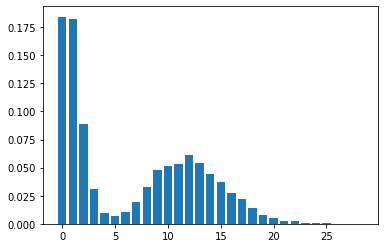

In [2]:
# check the function for my photon counts simulation funcion
t1 = time.time()
hist = rand_4Poisson_hist(0.5, 12, 0.5, 0.5, 0, repetitions=10000)
print("processing time new:", np.round( time.time()-t1, 4))

plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
plt.show()

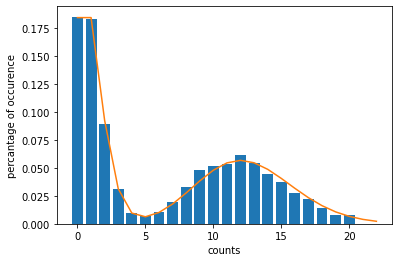

In [3]:
# manually set the pre fit
prefit = {'x': [24, 12.5, 1, 0, 0.5, 0.5]}

# fit the probability of down down, down up, up up
y_dd, y_du, y_uu,_,_,_ = eios_analyse.fit_hist_2I([hist], prefit, parallel = True)

# eios_analyse.plot_hist_res_2I(hist, prefit['x'][:3], [y_dd[0], y_du[0], y_uu[0]])

eios_analyse.plot_hist_res_2I(hist, prefit)

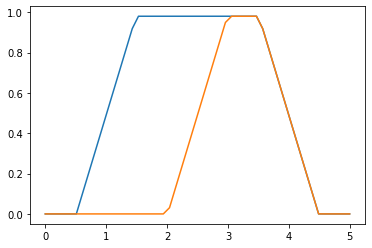

In [4]:
times = np.linspace(-0, 5, 50)

# define a simple ramp funciton
def rmp(t):
    if t <= 0.01:
        return 0.01
    elif 0.01<t<=0.99:
        return t
    else:
        return 0.99

Ps1 = np.array([rmp(t-0.5)-rmp(t-3.5) for t in times])
Ps2 = np.array([rmp(t - 2)-rmp(t-3.5) for t in times])

plt.plot(times, Ps1)
plt.plot(times, Ps2)
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 0, Ps1[i], Ps2[i]) for j in range(1000)])

In [5]:
# do the prefit to determine the three count levels (with all histograms)

t1 = time.time()
prefit = eios_analyse.fit_poisson_hist_2I(hists, 0.5, 10)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 2.301


In [6]:
# do the fits to determine the population of (down, down) and (down, up) = (up, down) and (up, up)

t1 = time.time()
# y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 0.2939


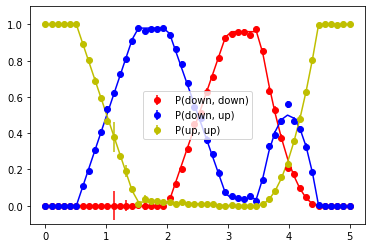

In [7]:
plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label='P(down, down)')
plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label='P(down, up)')
plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label='P(up, up)')

# fit results
# plt.plot(times, y_dd, 'ro', label=r'P($\downarrow \downarrow$)')
# plt.plot(times, y_du, 'bo', label=r'P($\downarrow \uparrow$)')
# plt.plot(times, y_uu, 'yo', label=r'P($\uparrow \uparrow$)')

# expectation
plt.plot(times, Ps1*Ps2, 'r-') # both down
plt.plot(times, (1-Ps1)*Ps2 + Ps1*(1-Ps2), 'b-') # one down one up
plt.plot(times, (1-Ps1)*(1-Ps2), 'y-') # both up
plt.ylim((-0.1, 1.1))
plt.legend()
plt.show()

This plot shows the results of the fit routine to get the population levels P(down, down), P(up, up) and P(down, up)=P(up, down).<br/>
The dots show the fitted results, and the lines the expectation (e.g. the initial values for the data simulation). It was assumed that the simulated histogram can be fitted on a three-poissonian-distribution, but the data was simulated using a four-poissonian-distribution, with expectation values for the (down, up) state slightly different to the expectation value for the (up, down) state.

3.163265306122449
values: [0.956 0.044 0.   ]
errors: [0.011 0.011 0.001]


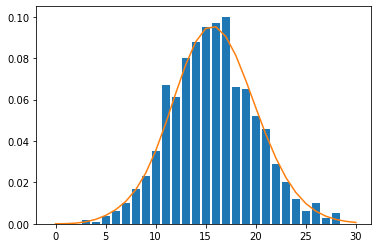

In [8]:
# plot one histogram with the fit
ii = 31

print(times[ii])

print('values:', np.round([y_dd[ii], y_du[ii], y_uu[ii]], 3))
print('errors:', np.round([y_err_dd[ii], y_err_du[ii], y_err_uu[ii]], 3))

eios_analyse.plot_hist_res_2I_old(hists[ii], np.flip(np.sort(prefit['x'][:3])), [y_dd[ii], y_du[ii], y_uu[ii]])

In [15]:
# eios_analyse.fit_hist_2I([hists[ii]], prefit, parallel = True)
eios_analyse.fit_hist_2I([hists[ii]], prefit, parallel = True)

([0.9574959818270132],
 [0.04160785425040647],
 [0.0008961639225803438],
 [0.010786140501704034],
 [0.010739153630078657],
 [0.0011077402393719763])

## simulate MW flop

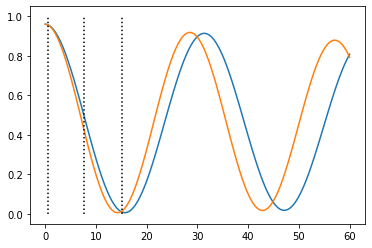

In [9]:
# simulate MW Flop
times = np.linspace(0, 60, 120)
iis = [1, 15, 30]

Ps1 = (0.48*(1+np.cos(0.2*times)) - 0.2) * np.exp(-0.002*times) + 0.2
Ps2 = (0.48*(1+np.cos(0.22*times)) - 0.21) * np.exp(-0.002*times) + 0.21

plt.plot(times, Ps1)
plt.plot(times, Ps2)
for ii in iis: plt.plot([times[ii], times[ii]], [0, 1], 'k:')
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 0, Ps1[i], Ps2[i]) for j in range(200)])

In [10]:
t1 = time.time()
prefit = eios_analyse.fit_poisson_hist_2I(hists, 0.5, 10)
print("processing time:", np.round( time.time()-t1, 4))

t1 = time.time()
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 1.0846
processing time: 0.309


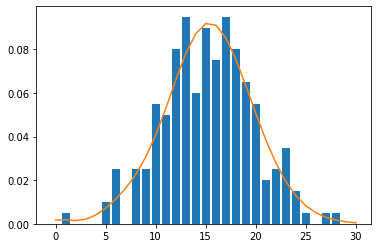

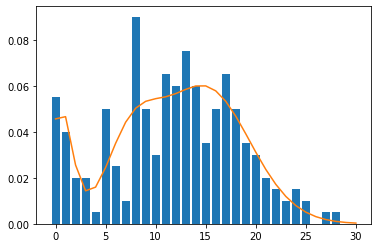

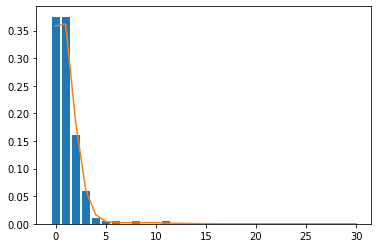

In [11]:
mus = np.flip(np.sort(prefit['x'][:3]))

for ii in [1, 10, 31]:
    eios_analyse.plot_hist_res_2I_old(hists[ii], mus, [y_dd[ii], y_du[ii], y_uu[ii]])

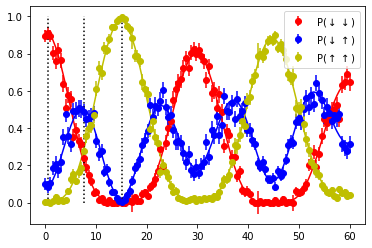

In [12]:
# fit results
plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label=r'P($\downarrow \downarrow$)')
plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label=r'P($\downarrow \uparrow$)')
plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label=r'P($\uparrow \uparrow$)')

# expectation
plt.plot(times, Ps1*Ps2, 'r-') # both down
plt.plot(times, (1-Ps1)*Ps2 + Ps1*(1-Ps2), 'b-') # one down one up
plt.plot(times, (1-Ps1)*(1-Ps2), 'y-') # both up

for ii in iis: plt.plot([times[ii], times[ii]], [0, 1], 'k:')
plt.legend()
plt.show()

## make errors asymmetric near bounds

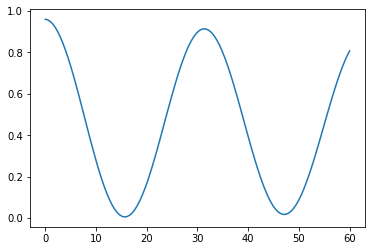

In [24]:
# simulate MW Flop
times = np.linspace(0, 60, 120)
iis = [1, 15, 30]

Ps = (0.499*(1+np.cos(0.2*times)))

plt.plot(times, Ps1)
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 0, Ps[i], Ps[i]) for j in range(200)])

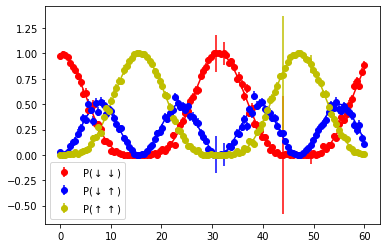

In [43]:
# fit results
# fit results
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)

plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label=r'P($\downarrow \downarrow$)')
plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label=r'P($\downarrow \uparrow$)')
plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label=r'P($\uparrow \uparrow$)')

# expectation
plt.plot(times, Ps**2, 'r-') # both down
plt.plot(times, 2*(1-Ps)*Ps, 'b-') # one down one up
plt.plot(times, (1-Ps)**2, 'y-') # both up

plt.legend()
plt.show()

In [60]:
i1 = np.argmax(np.array(y_dd)+np.array(y_err_dd))
i2 = np.argmax(np.array(y_uu)+np.array(y_err_uu))
i3 = np.argmin(np.array(y_du)-np.array(y_err_du))

print(y_dd[i1]+y_err_dd[i1])
print(y_uu[i2]+y_err_uu[i2])
print(y_du[i3]-y_err_du[i3])
print()

hists_as = [hists[i1], hists[i2], hists[i3]]

# y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)

eios_analyse.fit_hist_2I(hists_as, prefit, parallel = True, as_err = True)

1.1830138828947794
1.3662696374399117
-0.18299679674509794



/home/robboss/Documents/GitHub/Robin-Master/PyModules/analyse_eios/eios_analyse.py:45: RuntimeWarning: invalid value encountered in log
  + p_uu/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_uu))
/home/robboss/Documents/GitHub/Robin-Master/PyModules/analyse_eios/eios_analyse.py:45: RuntimeWarning: invalid value encountered in log
  + p_uu/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_uu))
/home/robboss/Documents/GitHub/Robin-Master/PyModules/analyse_eios/eios_analyse.py:45: RuntimeWarning: invalid value encountered in log
  + p_uu/(p_dd+p_du+p_uu)*poisson.pmf(data, mu_uu))


-------------------------------------------------
|     p_same      |           Invalid           |
-------------------------------------------------
|      Error      |    -0.021    |     0.183    |
|      Valid      |     True     |    False     |
|    At Limit     |    False     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
-------------------------------------------------
-------------------------------------------------
|      p_up       |            Valid            |
-------------------------------------------------
|      Error      |  -0.000E-3   |   2.500E-3   |
|      Valid      |     True     |     True     |
|    At Limit     |     True     |    False     |
|     Max FCN     |    False     |    False     |
|     New Min     |    False     |    False     |
--------------------------------------------------------------------------------------------------
|     p_same      |           Invalid           |
-

([0.999999999417796, 3.7652464635903947e-06, 0.999999999417796],
 [1.5262902053336802e-11, 0.21627620103119605, 1.5262902053336802e-11],
 [5.669410496536086e-10, 0.7837200337223403, 5.669410496536086e-10],
 [0.1830138834769834, 0.5817556241252351, 0.1830138834769834],
 [0.18299679676036085, 0.030404662023616913, 0.18299679676036085],
 [0.0025007916237262083, 0.5825496037175714, 0.0025007916237262083])

## get optimal detection time

In [50]:
def check_fidelity_sim_2I(histdd, histdu, histuu, printFid = True, Tdet = 50):
        # get the histograms
        hists = [histdd, histdu, histuu]

        # do a prefit with all three histograms combined to get the count levels
        prefit = eios_analyse.fit_poisson_hist_2I(hists, lowcount=Tdet/50. * 1., highcount=Tdet/50. * 8., limit = Tdet)
#         print(prefit)

        # calculate the fidelityies (= state population)
        fids_dd, fids_du, fids_uu, err_fid_dd, err_fid_du, err_fid_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = False)
        
#         print(fids_dd)
#         print(fids_du)
#         print(fids_uu)

        # print results
        if printFid:
            try:
                print('\n', "bright state fidelity: ", np.round(fids_dd[0], 3), "error: ", np.round(err_fid_dd[0], 3))
                print(" medium state fidelity:   ", np.round(fids_du[1], 3), "error: ", np.round(err_fid_du[1], 3))
                print(" dark state fidelity:   ", np.round(fids_uu[2], 3), "error: ", np.round(err_fid_uu[2], 3), '\n')
            except:
                print('\n', "some error !!!", '\n')

        try:
            return fids_dd[0], fids_du[1], fids_uu[2], err_fid_dd[0], err_fid_du[1], err_fid_uu[2]
        except:
            return np.nan, np.nan, np.nan, np.nan

In [78]:
t1 = time.time()
np.random.seed(420)

list_Tdet1 = np.linspace(50, 1500, 30)
list_Tdet2 = np.linspace(5, 100, 20)
list_Tdet2 = np.linspace(2, 80, 79)
list_Tdet3 = np.append(list_Tdet2, list_Tdet1)

list_Tdet = list_Tdet3

# try the leaking
init_fid = 0.99
n_exp = 10000
mu_up50 = 0.5
mu_down50 = 8
w_leak = 0.00233


MW_fidelitys = []
all_hists = []
for Tdet in list_Tdet:
    print('\r', "Tdet:", np.round(Tdet), end='')
#     print(Tdet)

    histdd = rand_4Poisson_hist(Tdet/50. * mu_up50, Tdet/50. * mu_down50, P_D1=init_fid, P_D2=init_fid, G_leak=Tdet*w_leak, repetitions = n_exp, parallel=False)
    histdu = rand_4Poisson_hist(Tdet/50. * mu_up50, Tdet/50. * mu_down50, P_D1=init_fid, P_D2=1-init_fid, G_leak=Tdet*w_leak, repetitions = n_exp, parallel=False)
    histuu = rand_4Poisson_hist(Tdet/50. * mu_up50, Tdet/50. * mu_down50, P_D1=1-init_fid, P_D2=1-init_fid, G_leak=Tdet*w_leak, repetitions = n_exp, parallel=False)

    MW_fidelitys.append(check_fidelity_sim_2I(histdd, histdu, histuu, printFid = False, Tdet = Tdet))
    all_hists.append([histdd, histdu, histuu])

print(' ')
print("processing time:", np.round( time.time()-t1, 4))

 Tdet: 1500.0 
processing time: 227.4446


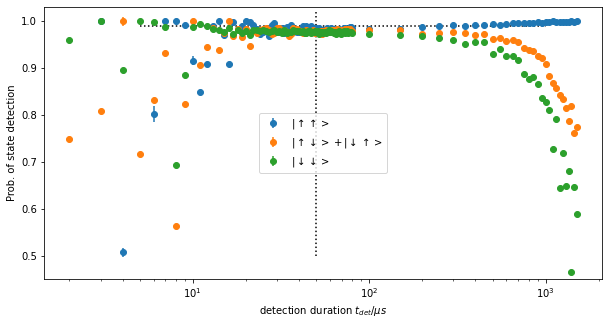

In [79]:
plt.figure(figsize=(10, 5))
plt.errorbar(list_Tdet, [fid[0] for fid in MW_fidelitys], [fid[3] for fid in MW_fidelitys], fmt = 'o', label=r'$|\uparrow \uparrow>$')
plt.errorbar(list_Tdet, [fid[1] for fid in MW_fidelitys], [fid[4] for fid in MW_fidelitys], fmt = 'o', label=r'$|\uparrow \downarrow>$')
plt.errorbar(list_Tdet, [fid[2] for fid in MW_fidelitys], [fid[5] for fid in MW_fidelitys], fmt = 'o', label=r'$|\downarrow \downarrow>$')
plt.plot([50, 50], [0.5, 1.02], 'k:')
plt.plot([5, 1000], [init_fid, init_fid], 'k:')
plt.xlabel(r'detection duration $t_{det}$/$\mu s$')
plt.ylabel(r'Prob. of state detection')
plt.ylim((0.45, 1.03))
plt.xscale('log')
plt.legend()
plt.show()

detection duration: 2.0


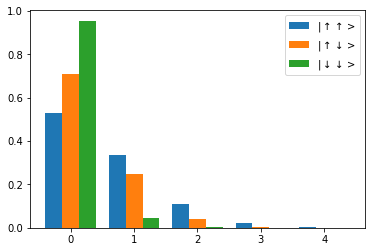

detection duration: 50.0


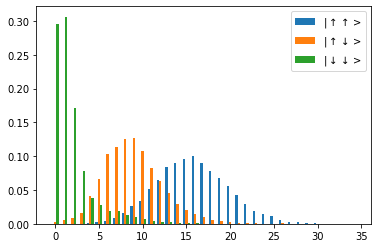

detection duration: 1500.0


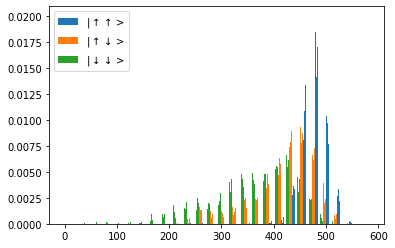

In [85]:
ids= [0, 79, -1]

for i in ids:
    print('detection duration:', list_Tdet[i])
    plt.hist(all_hists[i], bins=range(int(np.max(all_hists[i]))), label=[r'$|\uparrow \uparrow>$',r'$|\uparrow \downarrow>$', r'$|\downarrow \downarrow>$'], rwidth=0.8, align='left', density=True)
    plt.legend()
    plt.show()



# evaluate hamiltonian from "Exp. entanglement of four particles", 2000

In [20]:
psi0 = fock_dm(4, 0)

omega = 20
times = np.linspace(0, 0.5*np.pi, 100)

omega = 1

mat = Qobj([[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

res = mesolve(0.5*omega*mat, psi0, times)

In [21]:
psi = res.states[-1]

psi

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.49999946+0.j         0.        +0.j         0.        +0.j
  0.        +0.49999972j]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        -0.49999972j 0.        +0.j         0.        +0.j
  0.50000054+0.j        ]]

# Fit the MW flop probabilities

In [192]:
file = 'data/16_23_20_17_07_2020.dat'

res = eios_analyse.fit_poisson_from_file_2I(file, prefit = None, ret_prefit = False, onlyFirst = True)

In [193]:
np.shape(res)

(1, 7, 50)

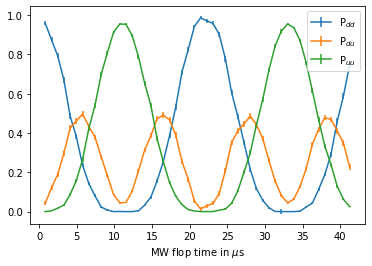

In [194]:
plt.errorbar(res[0][0], res[0][1], res[0][4], label=r'P$_{dd}$')
plt.errorbar(res[0][0], res[0][2], res[0][5], label=r'P$_{du}$')
plt.errorbar(res[0][0], res[0][3], res[0][6], label=r'P$_{uu}$')
plt.xlabel(r'MW flop time in $\mu$s')
plt.legend()
plt.show()

In [195]:
def P_flop_rob(x, Omega, phi, dec, A, lim):
    return(A*(0.5*np.cos(2*np.pi*Omega*x + phi)+0.5-lim) * np.exp(-dec*x) + lim)

def func(Omega, phi, dec, A, lim):    
    chisq_dd = [1/(res[0][4][i]**2)*(P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim)**2 - res[0][1][i])**2 for i in range(len(res[0][0]))]
    chisq_du = [1/(res[0][5][i]**2)*(2*P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim)*(1-P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim)) - res[0][2][i])**2 for i in range(len(res[0][0]))]
    chisq_uu = [1/(res[0][6][i]**2)*((1-P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim))**2 - res[0][3][i])**2 for i in range(len(res[0][0]))]
    return np.sum(chisq_dd)+np.sum(chisq_du)+np.sum(chisq_uu)

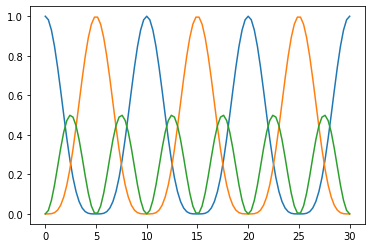

In [196]:
x = np.linspace(0, 30, 100)

plt.plot(x, P_flop_rob(x, 0.1*omega, phi, g, a, lim)**2)
plt.plot(x, (1-P_flop_rob(x, 0.1*omega, phi, g, a, lim))**2)
plt.plot(x, 2*P_flop_rob(x, 0.1*omega, phi, g, a, lim)*(1-P_flop_rob(x, 0.1*omega, phi, g, a, lim)))

In [197]:
m = iminuit.Minuit(func, Omega = 0.045, phi = 0.05, dec = 0.05, A = .8, lim = 0.8,
                   error_Omega = 0.01, error_phi = 0.1, error_dec = 0.005, error_A = 0.1, error_lim = 0.05, errordef = 1,
                   limit_phi = (0,2*np.pi), limit_A = (0,1), limit_lim = (0, 1))

# minimize the chi^2 function
m.migrad()

------------------------------------------------------------------
| FCN = 272                     |     Ncalls=378 (378 total)     |
| EDM = 1.16E-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|   | Name  |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-------------------------------------------------------------------------------------------
| 0 | Omega | 0.453E-1  | 0.000E-1  |            |            |         |         |       |
| 1 | phi   |  0.0E-3   |  0.8E-3   |            |            |    0    | 6.28319 |       |
| 2 | dec   |  1.3E-4   |  0.6E-4   |            |            |         |         |       |
| 3 | A     |   0.981   |   0.001   |            |            |    0    |    1    |       |
| 4 | lim   |   1.000   |   0.008   |            |            |    0    |    1    |       |
-------------------------------------------------------------------------------------------

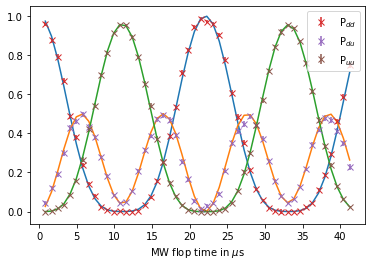

In [198]:
Omega = 0.0453
phi = 0.
dec = 1.9e-4
A = 0.967
lim = 0.863

Omega, phi, dec, A, lim = m.values[0], m.values[1], m.values[2], m.values[3], m.values[4]

P_dd = [P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim)**2 for i in range(len(res[0][0]))]
P_du = [2*(P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim))*(1-P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim)) for i in range(len(res[0][0]))]
P_uu = [(1-P_flop_rob(res[0][0][i], Omega, phi, dec, A, lim))**2 for i in range(len(res[0][0]))]

plt.plot(res[0][0], P_dd)
plt.plot(res[0][0], P_du)
plt.plot(res[0][0], P_uu)
# plt.show()

plt.errorbar(res[0][0], res[0][1], res[0][4], fmt = 'x', label=r'P$_{dd}$')
plt.errorbar(res[0][0], res[0][2], res[0][5],  fmt = 'x', label=r'P$_{du}$')
plt.errorbar(res[0][0], res[0][3], res[0][6], fmt = 'x', label=r'P$_{uu}$')
plt.xlabel(r'MW flop time in $\mu$s')
plt.legend()
plt.show()

In [182]:
m.values[0]

0.009497261603250255